# YouTube Video Engagement Analysis Project

## Notebook 2: ETL and EDA

In this notebook, we will extract the YouTube video metadata from S3,
transform the data as needed, and perform exploratory data analysis (EDA).

##  ETL: Extract, Transform, Load.
We gather the data from its sources (Youtube in our case), We preprocess it in order to convert it into meaningful data so that we can Load the data into our models.
However, since we are in the exploratory stage, before we can load the data, we need to Extract use ful features. For this, we perform EDA (Next section), before we can use the Data in our models and analysis

In [17]:
import boto3


# Download CSV from S3
client = boto3.client(
    's3',
    aws_access_key_id="",
    aws_secret_access_key="",
)
client.download_file('electric-scooters', 'youtube_metadata.csv', 'youtube_metadata.csv')

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

Transformations and preprocesses are needed to bring the data in the useful manner, highlighting the relevant contexts we are looking for

In [10]:
# Load data
df = pd.read_csv('youtube_metadata.csv')

# Data transformation
# Convert counts to integers
df['view_count'] = df['view_count'].astype(int)
df['like_count'] = df['like_count'].astype(int)
df['dislike_count'] = df['dislike_count'].astype(int)
df['comment_count'] = df['comment_count'].astype(int)

# Convert published_at to datetime
df['published_at'] = pd.to_datetime(df['published_at'])

# Extract relevant features for analysis
df['duration_seconds'] = pd.to_timedelta(df['duration']).dt.total_seconds()
df['tags_count'] = df['tags'].apply(len)

# Combine tags and description for text analysis
df['text'] = df['tags'].apply(lambda x: ' '.join(x)) + ' ' + df['description']

In [12]:
# Remove non UTF-8 Characters to process text
def keep_utf8_characters(text):
    try:
        # Encode to utf-8 and decode to remove invalid characters
        return text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')
    except:
        # If there's an error, return an empty string
        return ''

df['text'] = df['text'].apply(keep_utf8_characters)
df['text']

0     [ ' b e s t   e l e c t r i c   s c o o t e r ...
1                                [ ] #topspeed DOWNHILL
2     [ ' W E P E D   S o n i c ' ,   ' W E P E D ' ...
3                                                      
4     [ ' N e w ' ,   ' E l e c t r i c ' ,   ' E   ...
5                                                      
6     [ ' E l e c t r i c   S c o o t e r ' ,   ' b ...
7     [ ' Z i g W h e e l s ' ,   ' Z i g w h e e l ...
8                                                      
9     [ ] This scooter has a lock, handle, passcode,...
10    [ ' X i a o m i ' ,   ' R e d m i ' ,   ' X i ...
11                                                     
12    [ ' b e s t   f a t   t i r e   e l e c t r i ...
13    [ ' h o w   t o ' ,   ' t u t o r i a l ' ,   ...
14    [ ' b u g a t t i ' ,   ' b u g a t i ' ,   ' ...
15    [ ] Full review video: https://youtu.be/gkyZ9e...
16    [ ' e l e c t r i c   s c o o t e r ' ,   ' b ...
17    [ ] 5 scooters under $700 review: https://

In [13]:
# Text processing: TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Join TF-IDF features with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)

In [16]:
# Calculate percentiles for classification thresholds
percentile_33 = df['view_count'].quantile(0.33)
percentile_66 = df['view_count'].quantile(0.66)

# Define engagement classes
def classify_engagement(likes):
    if likes <= percentile_33:
        return 0
    elif likes <= percentile_66:
        return 1
    else:
        return 2

df['engagement_class'] = df['view_count'].apply(classify_engagement)

# Exploratory Data Analysis (EDA)
The aim is to visualise the relationships between variables in order to use them for data analysis and modeling

We plot all the potential processed data and observe the graphs for correlations.
Ideally we want to see data points similir to a function and not mapped along a vertical or horitonzal axes.
For example in the below graphs, like_count as a visible relation with view_count, comment_count, duration and tag_count; but not relation with dislike_count; and te strongest relation with comment_count.

Some of these relations may make sense due to the context, but the point to note here is that we also have an observable mathematical relation. which we can use depending of the kind of analysis, prediction or insights we are looking for from the data.

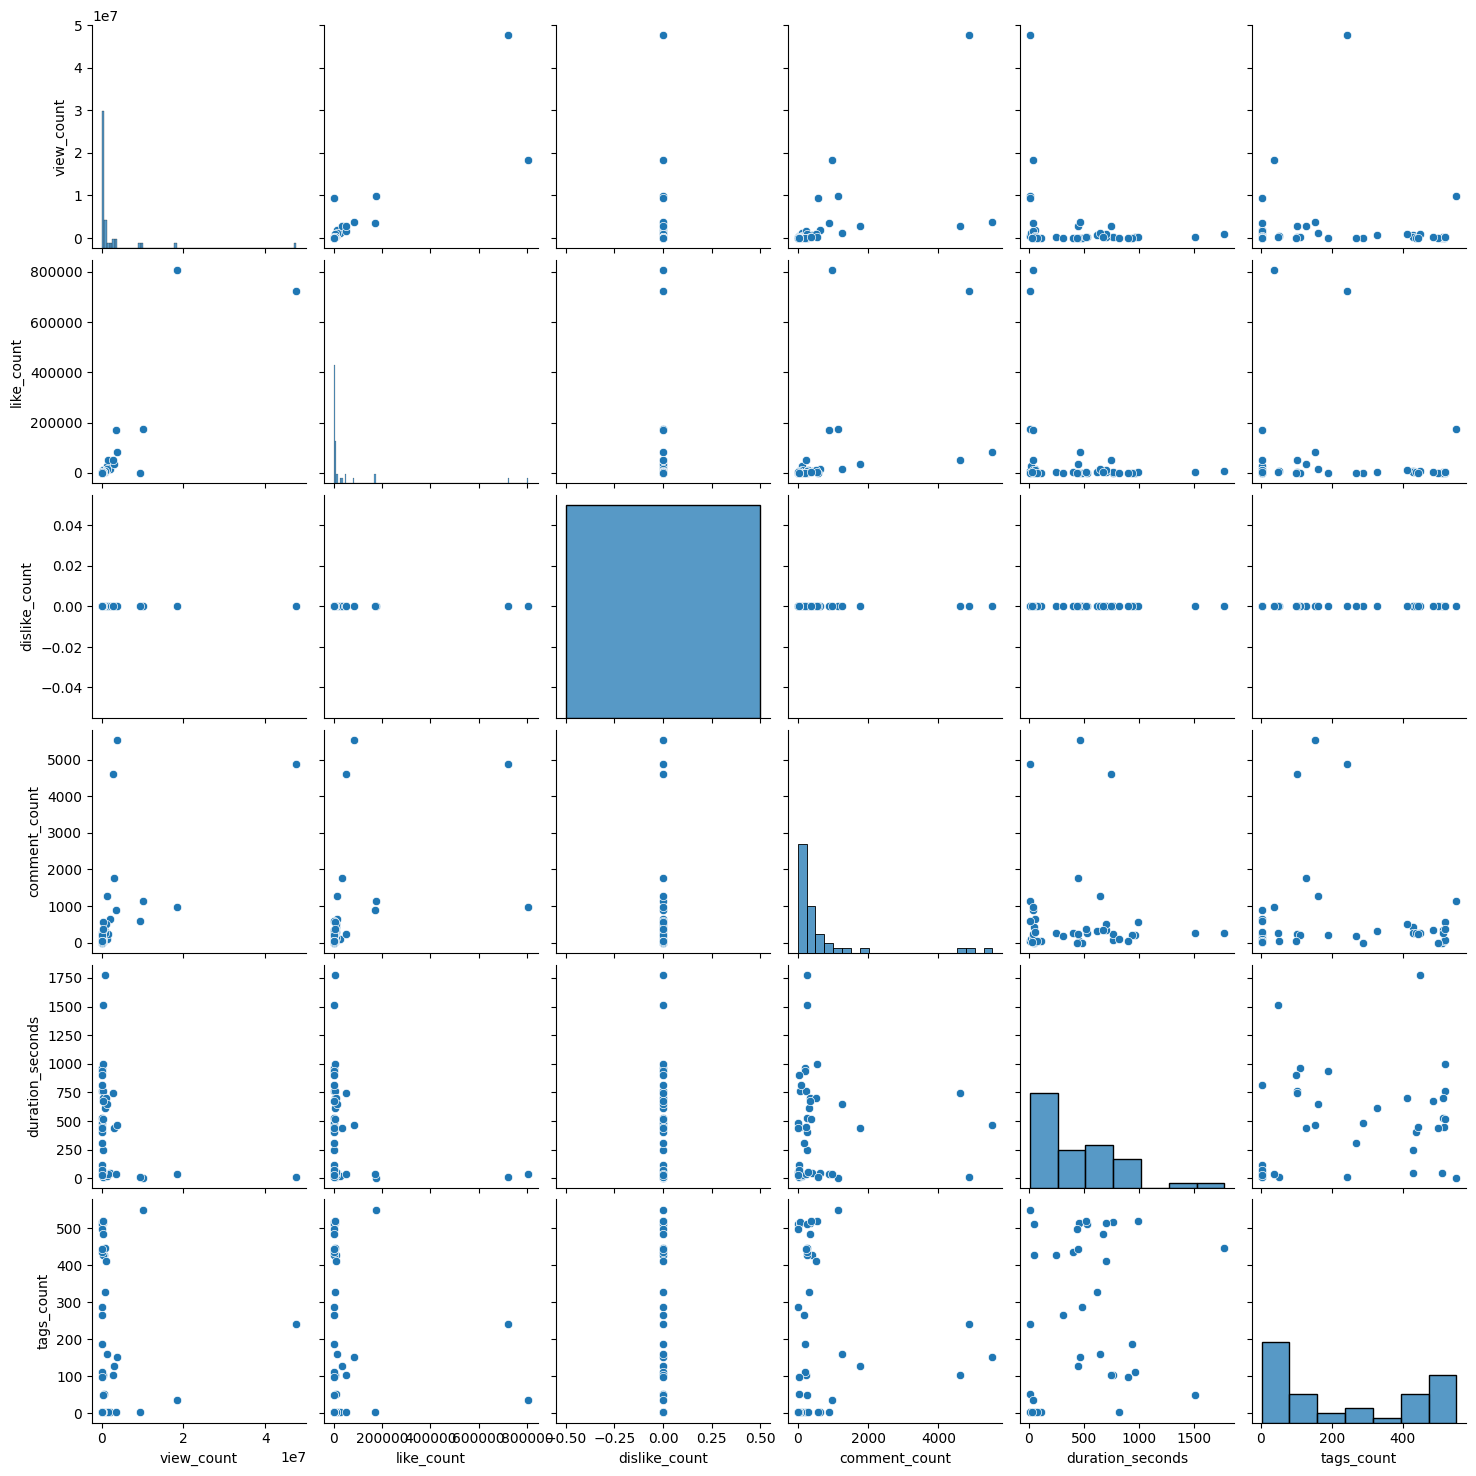

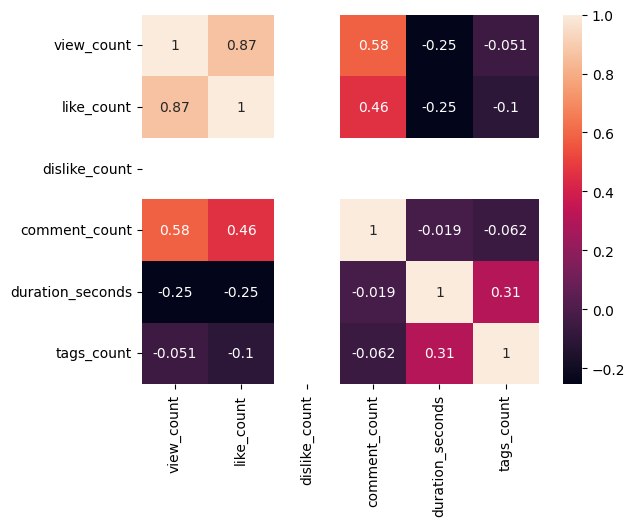

         view_count     like_count  dislike_count  comment_count  \
count  4.500000e+01      45.000000           45.0      45.000000   
mean   2.502043e+06   50197.244444            0.0     642.111111   
std    7.641444e+06  160577.378316            0.0    1240.565051   
min    3.810000e+02       0.000000            0.0       0.000000   
25%    1.009340e+05     949.000000            0.0      58.000000   
50%    2.998970e+05    4243.000000            0.0     251.000000   
75%    1.234930e+06   10358.000000            0.0     512.000000   
max    4.765507e+07  806344.000000            0.0    5538.000000   

       duration_seconds  tags_count  
count         45.000000   45.000000  
mean         423.000000  223.800000  
std          421.176221  212.660164  
min            8.000000    2.000000  
25%           47.000000    2.000000  
50%          441.000000  152.000000  
75%          702.000000  444.000000  
max         1777.000000  551.000000  


In [14]:

# Pairplot to visualize relationships between numerical features
sns.pairplot(df[['view_count', 'like_count', 'dislike_count', 'comment_count', 'duration_seconds', 'tags_count']])
plt.show()

# Heatmap to visualize correlations between numerical features
sns.heatmap(df[['view_count', 'like_count', 'dislike_count', 'comment_count', 'duration_seconds', 'tags_count']].corr(), annot=True)
plt.show()

# Basic statistics to understand the distribution of features
print(df[['view_count', 'like_count', 'dislike_count', 'comment_count', 'duration_seconds', 'tags_count']].describe())